In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [2]:
# Load dataset for both training and testing

# Define Columns
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

# Training data
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_df = pd.read_csv(train_url, header=None, names=columns, na_values=' ?')

# Testing data
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_df = pd.read_csv(test_url, header=None, names=columns, skiprows=1, na_values=' ?')

print(f'Dimension of testing data is: {test_df.shape}')
print(f' Dimension of training data is: {train_df.shape}')


Dimension of testing data is: (16281, 15)
 Dimension of training data is: (32561, 15)


In [3]:
# Combine both testing and training data into a single data
df = pd.concat([test_df, train_df], axis=0)

In [4]:
# Dimension of the combined data
df.shape

(48842, 15)

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
# Check the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


In [7]:
#Check for duplicates
df.duplicated().sum()

np.int64(29)

In [8]:
# Drop the duplicates
df.drop_duplicates(inplace=True)

In [9]:
# Check for missing values
df.isna().sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,2809
relationship,0
race,0
sex,0


In [10]:
# Drop Missing values
df.dropna(inplace=True)

In [11]:
print(df)

       age      workclass  fnlwgt      education  education-num  \
0       25        Private  226802           11th              7   
1       38        Private   89814        HS-grad              9   
2       28      Local-gov  336951     Assoc-acdm             12   
3       44        Private  160323   Some-college             10   
5       34        Private  198693           10th              6   
...    ...            ...     ...            ...            ...   
32556   27        Private  257302     Assoc-acdm             12   
32557   40        Private  154374        HS-grad              9   
32558   58        Private  151910        HS-grad              9   
32559   22        Private  201490        HS-grad              9   
32560   52   Self-emp-inc  287927        HS-grad              9   

            marital-status          occupation    relationship    race  \
0            Never-married   Machine-op-inspct       Own-child   Black   
1       Married-civ-spouse     Farming-fishing 

In [12]:
df.income.value_counts()

,count
income,
<=50K,22633
<=50K.,11355
>50K,7506
>50K.,3700


In [13]:
# Clean the 'income' column
df['income'] = df['income'].str.strip()


In [14]:
# Convert to numeric
df['income'] = df['income'].replace({
    '<=50K':0,
    '>50K':1
})

# Convert income column to numeric and drop values replaced with nan
df['income'] = pd.to_numeric(df['income'], errors='coerce')
df.dropna(subset=['income'], inplace=True)

# convert to type integer
df['income'] = df['income'].astype(int)

In [15]:
df.income.value_counts()

,count
income,
0,22633
1,7506


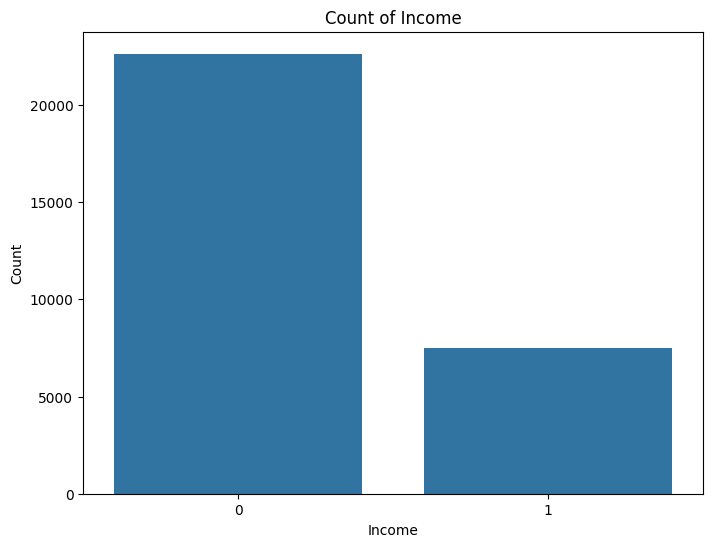

In [16]:
# Make a countplot of income distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Count of Income')
plt.show()

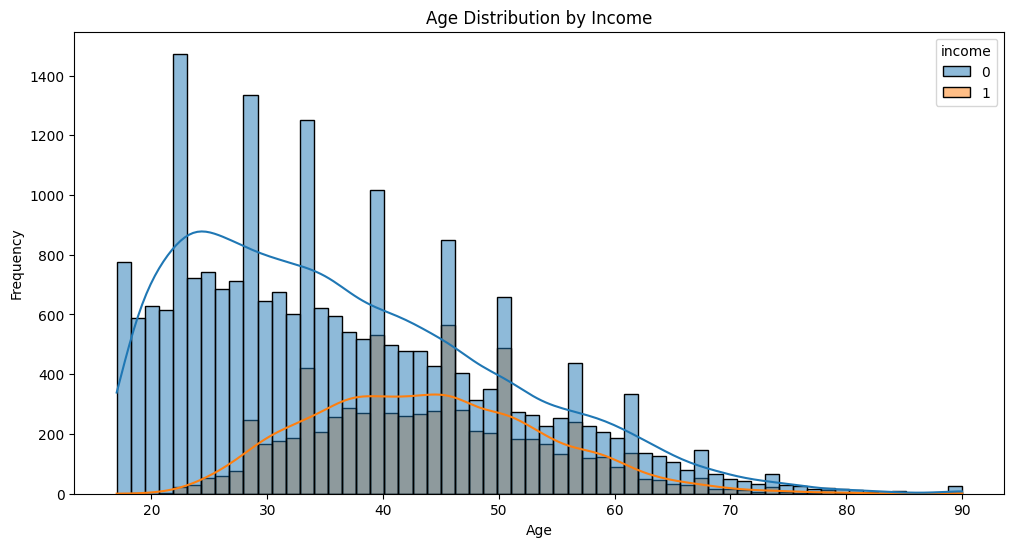

In [17]:
# Make histplot of age distribution by income
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='income', kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Income')
plt.show()

In [18]:
# Split features and target
X = df.drop("income", axis=1)
y = df["income"]

print(y.shape)
print(X.shape)

(30139,)
(30139, 14)


In [20]:
# Identify numerical and categorical columns

# Updated column names to match the DataFrame
numeric = ['age', 'capital-gain', 'education-num',
                   'capital-loss', 'hours-per-week']
categorical = ['workclass', 'marital-status', 'occupation',
                      'relationship', 'education', 'sex']

# Create processing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)
])

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Transform the features
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [23]:
X_train_prep.shape

(24111, 57)

In [48]:
#Finding the best hyperparameters for decision tree using GridSearchCV
start = time.time()
params_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params_grid, scoring='accuracy', cv=5, n_jobs=-1)

#Train the model
tree_grid.fit(X_train_prep, y_train)

#Extract the best parameters
best_params = tree_grid.best_params_

# Print the best parameters used
print(f' Best Decision Tree Parameters: {best_params}')

# Create decision tree model with the best parameters
tree_model = DecisionTreeClassifier(**best_params, random_state=42)
tree_model.fit(X_train_prep, y_train)
tree_time = time.time() - start

# Use the best model to predict test data
y_tree_pred = tree_model.predict(X_test_prep)
y_tree_proba = tree_model.predict_proba(X_test_prep)[:, 1]


# Print the accuracy and report
print(f' GreedSearch Best Score:  {tree_grid.best_score_}')
print(f' Decision Tree -  Report using (GridSearch)')
print(classification_report(y_test, y_tree_pred))
print(f'Text Accuracy score is: {accuracy_score(y_test, y_tree_pred)}')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_tree_pred))


 Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
 GreedSearch Best Score:  0.8518103966262173
 Decision Tree -  Report using (GridSearch)
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4527
           1       0.79      0.53      0.64      1501

    accuracy                           0.85      6028
   macro avg       0.83      0.74      0.77      6028
weighted avg       0.84      0.85      0.84      6028

Text Accuracy score is: 0.8488719309887193
Confusion Matrix:
 [[4317  210]
 [ 701  800]]


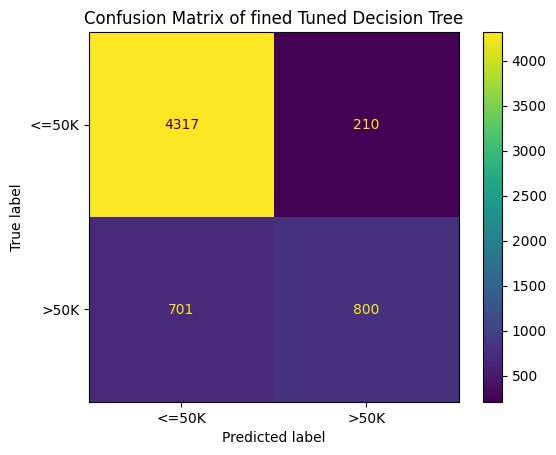

In [25]:
# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_tree_pred, display_labels=["<=50K", ">50K"], cmap='viridis')
plt.title("Confusion Matrix of fined Tuned Decision Tree")
plt.show()

In [27]:
# Finding the best hyperparameters for random forest with GridSearchCV
start = time.time()
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=rf_params,
                       scoring='accuracy',
                       cv=3,
                       n_jobs=-1)

#Train the model
rf_grid.fit(X_train_prep, y_train)

#Extract the best parameters
best_params = rf_grid.best_params_
print(f'Best Random Forest Parameters:", {best_params}')


# Create random forest model with the best parameters
rf_model = RandomForestClassifier(**best_params, random_state=42)


# Fit the model
rf_model.fit(X_train_prep, y_train)

rf_time = time.time() - start

#Use the best model to predict
y_rf_pred = rf_model.predict(X_test_prep)
y_rf_proba = rf_model.predict_proba(X_test_prep)[:, 1]

# Model evaluation
print(f' GreedSearch Best Score: {rf_grid.best_score_}')
print('Random Forest -  Report using (GridSearch)')
print(classification_report(y_test, y_rf_pred))
print(f' Test Accuracy score is: {accuracy_score(y_test, y_rf_pred)}')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_rf_pred))

Best Random Forest Parameters:", {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
 GreedSearch Best Score: 0.8590270001244246
Random Forest -  Report using (GridSearch)
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4527
           1       0.79      0.59      0.68      1501

    accuracy                           0.86      6028
   macro avg       0.83      0.77      0.79      6028
weighted avg       0.85      0.86      0.85      6028

 Test Accuracy score is: 0.8581619110816191
Confusion Matrix:
 [[4284  243]
 [ 612  889]]


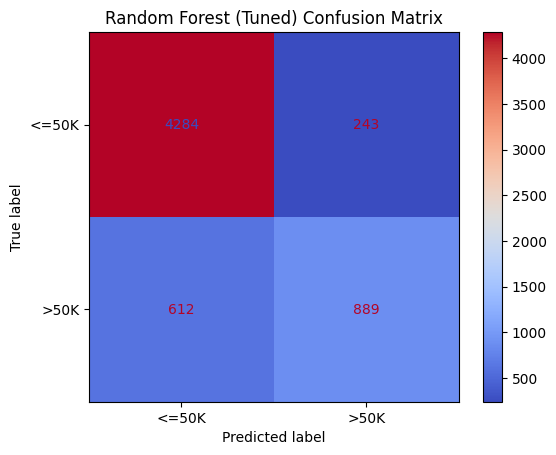

In [28]:
# Display thr confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_rf_pred, display_labels=["<=50K", ">50K"], cmap='coolwarm')
plt.title("Random Forest (Tuned) Confusion Matrix")
plt.show()

In [46]:
# Train Artificial Neural Network (ANN)
start = time.time()

model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_prep.shape[1],), kernel_regularizer=regularizers.l2(0.01)), Dropout(0.5),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)), Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assign the output of model.fit to history
history = model.fit(X_train_prep, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', min_delta=0.01)])
y_pred_ann = (model.predict(X_test_prep) > 0.5).astype("int32").flatten()
y_ann_proba = model.predict(X_test_prep).flatten()
ann_time = time.time() - start

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7437 - loss: 0.9300 - val_accuracy: 0.8292 - val_loss: 0.4661
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8230 - loss: 0.4724 - val_accuracy: 0.8404 - val_loss: 0.3938
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8360 - loss: 0.4150 - val_accuracy: 0.8404 - val_loss: 0.3780
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8338 - loss: 0.4081 - val_accuracy: 0.8425 - val_loss: 0.3687
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8379 - loss: 0.3966 - val_accuracy: 0.8408 - val_loss: 0.3680
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8380 - loss: 0.3940 - val_accuracy: 0.8367 - val_loss: 0.3669
Epoch 7/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8318 - loss: 0.3900 - val_accuracy: 0.8396 - val_loss: 0.3653
Epoch 8/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8393 - loss: 0.3844 - val_accuracy: 0.8420 - val_

In [47]:
#Print the ANN Report
print("ANN Classification Report")
print(classification_report(y_test, y_pred_ann))
print(f'Test Accuracy score is: {accuracy_score(y_test, y_pred_ann)}')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))

ANN Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4527
           1       0.77      0.54      0.63      1501

    accuracy                           0.85      6028
   macro avg       0.82      0.74      0.77      6028
weighted avg       0.84      0.85      0.84      6028

Test Accuracy score is: 0.8455540809555409
Confusion Matrix:
 [[4288  239]
 [ 692  809]]


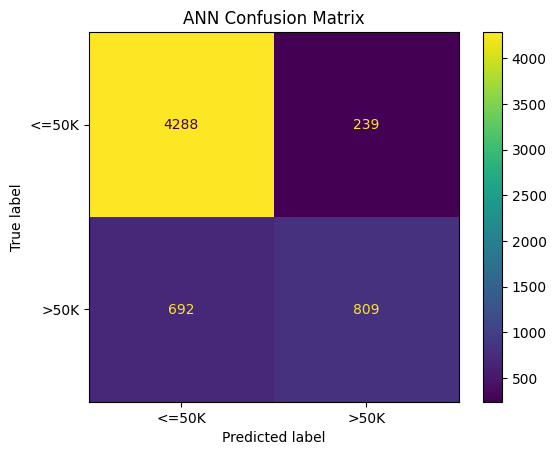

In [49]:
#Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ann), display_labels=["<=50K", ">50K"]).plot(cmap='viridis')
plt.title("ANN Confusion Matrix")
plt.show()

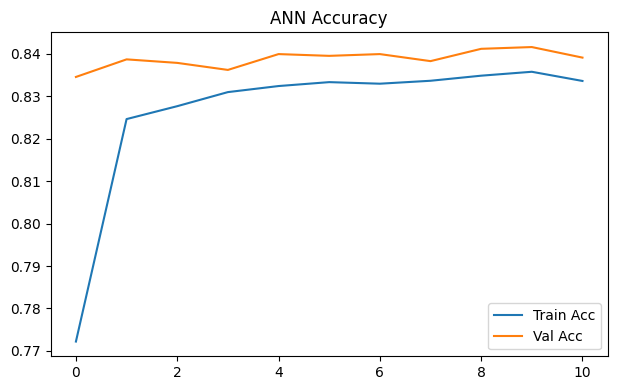

In [32]:
#Plot the Train Accuracy and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("ANN Accuracy")
plt.legend()
plt.tight_layout()

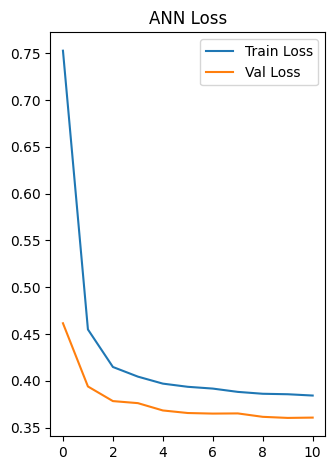

In [33]:
# Plot the Train loss and Validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("ANN Loss")
plt.legend()
plt.tight_layout()
plt.show()


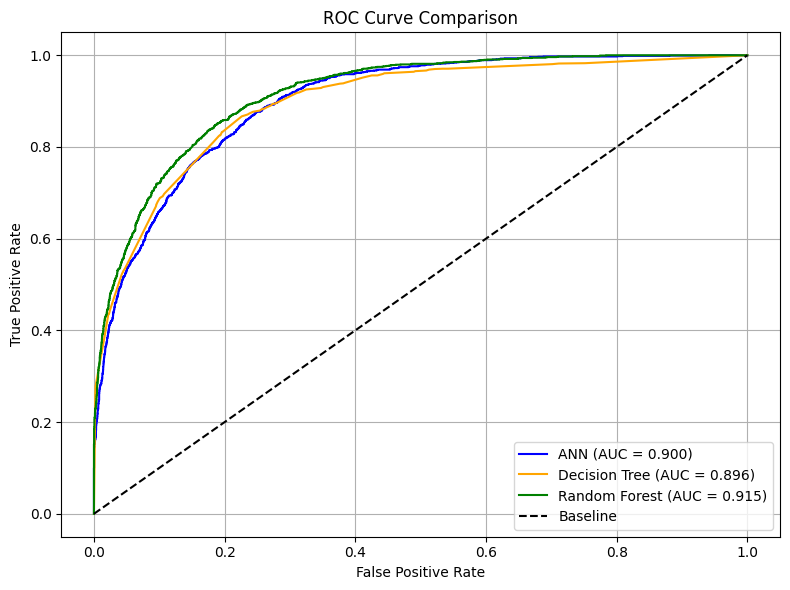

In [50]:
# Evaluate and compare the 3 model with ROC curve
# ANN
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_ann_proba)
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_tree_proba)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot all together
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f"ANN (AUC = {roc_auc_ann:.3f})", color='blue')
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.3f})", color='orange')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})", color='green')

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Set title and labels
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Print the training time of each model
print("Training Time (seconds):")
print(f"ANN:           {ann_time:.2f} sec")
print(f"Decision Tree: {tree_time:.2f} sec")
print(f"Random Forest: {rf_time:.2f} sec")

Training Time (seconds):
ANN:           19.52 sec
Decision Tree: 46.94 sec
Random Forest: 252.54 sec
